In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data Exploration
General Notes:
- The files that do not follow the naming conventions have missing metadata (Root Attributes in h5)

In [2]:
import re

import h5py
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from roar import ALL_VEHICLES, DATA_DIR, EXTRAS_DIR, VEHICLE_CLEAN_NAMES

In [3]:
# Some data cleaning for better usability
all_channel_names = pl.read_csv(EXTRAS_DIR / "all_measurement_channels name.csv")
all_channel_names = all_channel_names.with_columns(
    pl.col("vehicle")
    .str.replace(" ", "")
    .str.split(",")
    .replace(VEHICLE_CLEAN_NAMES)
    .replace({tuple(["alle"]): ALL_VEHICLES}),
    pl.col("relevance").cast(pl.Categorical),
)
all_channel_names

description,channel_name,synonym_1,synonym_2,vehicle,relevance
str,str,str,str,list[str],cat
"""Fzg-CAN - Antrieb""","""Antrieb""",null,null,"[""ID.4""]","""nein"""
"""Fzg-CAN""","""BCM1_Aussen_Temp""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""HEAD-CAN - labCTRL""","""CAN1_labCTRLI_""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""nein"""
"""HEAD-CAN - labDX""","""CAN1_labDX_B""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""nein"""
"""SIS - Trailing Edge - K1""","""Ch_1_labV12""","""TrailK1""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
…,…,…,…,…,…
"""iMAR""","""v_east_CAN_Sig_""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""iMAR""","""v_north_CAN_Sig""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""iMAR""","""v_up_CAN_Sig_11""","""v_up_CAN_Sig_21""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""


In [4]:
# Speed/measurement type information
speed_info = pl.read_csv(EXTRAS_DIR / "speed.csv")
speed_info

messtyp,short_name,meas_name,min_kph,max_kph,acceleration
str,str,str,i64,i64,i64
"""v1 = 45 km/h / 80 km/h""","""v1""","""mess0""",45,80,null
"""v2 = 80 km/h / 100 km/h""","""v2""","""mess1""",80,100,null
"""v3 = 100 km/h / 120 km/h""","""v3""","""mess2""",100,120,null
"""a1 = 1 m/s²""","""a1""","""mess3""",null,null,1
"""a2 = 2 m/s²""","""a2""","""mess4""",null,null,2
"""a3 = 3 m/s²""","""a3""","""mess5""",null,null,3


In [5]:
# Track information
tracks = pl.read_csv(EXTRAS_DIR / "tracks.csv")
tracks

track_ID,name,gps,gps_start,gps_ende
i64,str,str,str,str
150,"""Unknown Test Track""",null,null,null
211,"""ika Teststrecke""","""50.79101691007796, 6.048780870…","""50.79115036301304, 6.049006938…","""50.790885556264705, 6.04855011…"
259,"""ika - ISO""","""50.79101691007796, 6.048780870…","""50.79115036301304, 6.049006938…","""50.790885556264705, 6.04855011…"


In [6]:
# tyre information
tyres = pl.read_csv(EXTRAS_DIR / "tyres.csv")
tyres

tyre_ID,hersteller,name,dimension,fahrzeug
i64,str,str,str,str
1,"""Continental""","""EcoContact 6 Q ""","""235/55R19 105H""","""ID.4"""
3,"""Uniroyal""","""RainSport 5 ""","""235/55R19 105V""","""ID.4"""
6,"""Continental""","""Premium Contact 6 AO""","""255/50R20 109H""","""Q8 e-tron"""
10,"""Pirelli""","""P-Zero R""","""275/35R21 103Y""","""Taycan"""
12,"""Hankook""","""Ventus S1 evo3 ev""","""255/50R20 109H""","""Q8 e-tron"""
13,"""BFGoodrich""","""Summer SRTT""","""225/45R17 94V""","""E-Golf"""


## h5 files

In [7]:
# List all h5 files in the data directory
h5_files = [p for p in DATA_DIR.rglob("*.h5") if "HDF_Test_Export" not in str(p)]

files_df = pl.DataFrame(
    {
        "file_path": h5_files,
        "stem": [f.stem for f in h5_files],
        "track_ID": [int(file.parent.parent.parent.name) for file in h5_files],
        "tyre_ID": [int(re.search(r"Tyre\s*(\d+)", s.parent.name).group(1)) for s in h5_files],  # type: ignore
        "vehicle": [file.parent.parent.name for file in h5_files],
        "conventional_naming": [f.stem.startswith("track") for f in h5_files],
    }
)
files_df

file_path,stem,track_ID,tyre_ID,vehicle,conventional_naming
object,str,i64,i64,str,bool
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b50_ID4_RainSport5_ikaISO_2pt6_vr50_2025-07-11_10-40-06.h5,"""b50_ID4_RainSport5_ikaISO_2pt6…",259,3,"""01 VW ID4""",false
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b50_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_10-03-24.h5,"""b50_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-57-46.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/ID4_RainSport5_ikaISO_3pt1_vr45_2025-07-11_09-39-41.h5,"""ID4_RainSport5_ikaISO_3pt1_vr4…",259,3,"""01 VW ID4""",false
…,…,…,…,…,…
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas3_2p5_1_2025-09-23_17-27-29.h5,"""track150_Taycan_tyre10_meas3_2…",150,10,"""03 Porsche Taycan""",true
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas1_2p5_1_2025-09-23_17-22-54.h5,"""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas3_2p5_1_2025-09-23_17-26-43.h5,"""track150_Taycan_tyre10_meas3_2…",150,10,"""03 Porsche Taycan""",true


In [8]:
# Extract measurement and date
files_df = files_df.with_columns(
    pl.when(pl.col("conventional_naming"))
    .then(pl.col("stem").str.extract(r"(meas\d+)", 1))
    .otherwise(
        pl.when(pl.col("stem").str.starts_with("b"))
        .then(
            pl.concat_str(
                [
                    pl.col("stem").str.extract(r"^(b\d+)", 1),
                    pl.lit("_vr"),
                    pl.col("stem").str.extract(r"vr(\d+)", 1),
                ]
            )
        )
        .otherwise(
            pl.concat_str(
                [
                    pl.lit("vr"),
                    pl.col("stem").str.extract(r"vr(\d+)", 1),
                ]
            )
        )
    )
    .alias("masurement"),
    # extract timestamp (as string)
    pl.col("stem")
    .str.extract(r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})", 1)
    .str.strptime(pl.Datetime, "%Y-%m-%d_%H-%M-%S")
    .alias("date"),
)
files_df

file_path,stem,track_ID,tyre_ID,vehicle,conventional_naming,masurement,date
object,str,i64,i64,str,bool,str,datetime[μs]
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b50_ID4_RainSport5_ikaISO_2pt6_vr50_2025-07-11_10-40-06.h5,"""b50_ID4_RainSport5_ikaISO_2pt6…",259,3,"""01 VW ID4""",false,"""b50_vr50""",2025-07-11 10:40:06
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b50_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_10-03-24.h5,"""b50_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b50_vr50""",2025-07-11 10:03:24
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-57-46.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:57:46
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/ID4_RainSport5_ikaISO_3pt1_vr45_2025-07-11_09-39-41.h5,"""ID4_RainSport5_ikaISO_3pt1_vr4…",259,3,"""01 VW ID4""",false,"""vr45""",2025-07-11 09:39:41
…,…,…,…,…,…,…,…
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas3_2p5_1_2025-09-23_17-27-29.h5,"""track150_Taycan_tyre10_meas3_2…",150,10,"""03 Porsche Taycan""",true,"""meas3""",2025-09-23 17:27:29
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas1_2p5_1_2025-09-23_17-22-54.h5,"""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:22:54
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas3_2p5_1_2025-09-23_17-26-43.h5,"""track150_Taycan_tyre10_meas3_2…",150,10,"""03 Porsche Taycan""",true,"""meas3""",2025-09-23 17:26:43


In [10]:
import numpy as np


def extract_h5_variables(filename):
    """Extract variable information from an HDF5 file."""
    variables = []

    with h5py.File(filename, "r") as f:

        def collect_datasets(name, obj):
            if isinstance(obj, h5py.Dataset):
                # Get sample_rate from attributes if it exists
                sample_rate = obj.attrs.get("sample_rate", None)
                if isinstance(sample_rate, np.ndarray):
                    sample_rate = sample_rate.astype(np.int32).item()
                else:
                    sample_rate = None

                variables.append(
                    {
                        "variable_name": name,
                        "variable_shape": list(obj.shape),
                        "sample_rate": sample_rate,
                    }
                )

        f.visititems(collect_datasets)

    return variables


def expand_files_with_variables_efficient(files_df, filename_col="file_path"):
    """More efficient version using Polars operations."""
    struct_schema = pl.Struct(
        {
            "variable_name": pl.Utf8,
            "variable_shape": pl.List(pl.Int64),
            "sample_rate": pl.Int32,
        }
    )

    # Apply extraction to each file and explode
    expanded_df = (
        files_df.with_columns(
            pl.col(filename_col)
            .map_elements(extract_h5_variables, return_dtype=pl.List(struct_schema))
            .alias("variables")
        )
        .explode("variables")
        .unnest("variables")
    )

    return expanded_df


files_df_expanded = expand_files_with_variables_efficient(files_df)
files_df_expanded

file_path,stem,track_ID,tyre_ID,vehicle,conventional_naming,masurement,date,variable_name,variable_shape,sample_rate
object,str,i64,i64,str,bool,str,datetime[μs],str,list[i64],i32
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Antrieb""","[1, 250200]",36000
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""BCM1_Aussen_Temp""","[1, 6950]",1000
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Cnt_CAN_Sig_0_""","[1, 6950]",1000
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Cnt_CAN_Sig_12_""","[1, 6950]",1000
/Users/moritzfeik/Developer/ROAR/data_cleaned/259/01 VW ID4/02 UniRoyal RainSport5 - Tyre3/b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5,"""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Cnt_CAN_Sig_16_""","[1, 6950]",1000
…,…,…,…,…,…,…,…,…,…,…
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas1_2p5_1_2025-09-23_17-21-41.h5,"""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:21:41,"""v_east_CAN_Sig_""","[1, 6650]",1000
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas1_2p5_1_2025-09-23_17-21-41.h5,"""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:21:41,"""v_north_CAN_Sig""","[1, 6650]",1000
/Users/moritzfeik/Developer/ROAR/data_cleaned/150/03 Porsche Taycan/Tyre10/track150_Taycan_tyre10_meas1_2p5_1_2025-09-23_17-21-41.h5,"""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:21:41,"""v_up_CAN_Sig_11""","[1, 6650]",1000


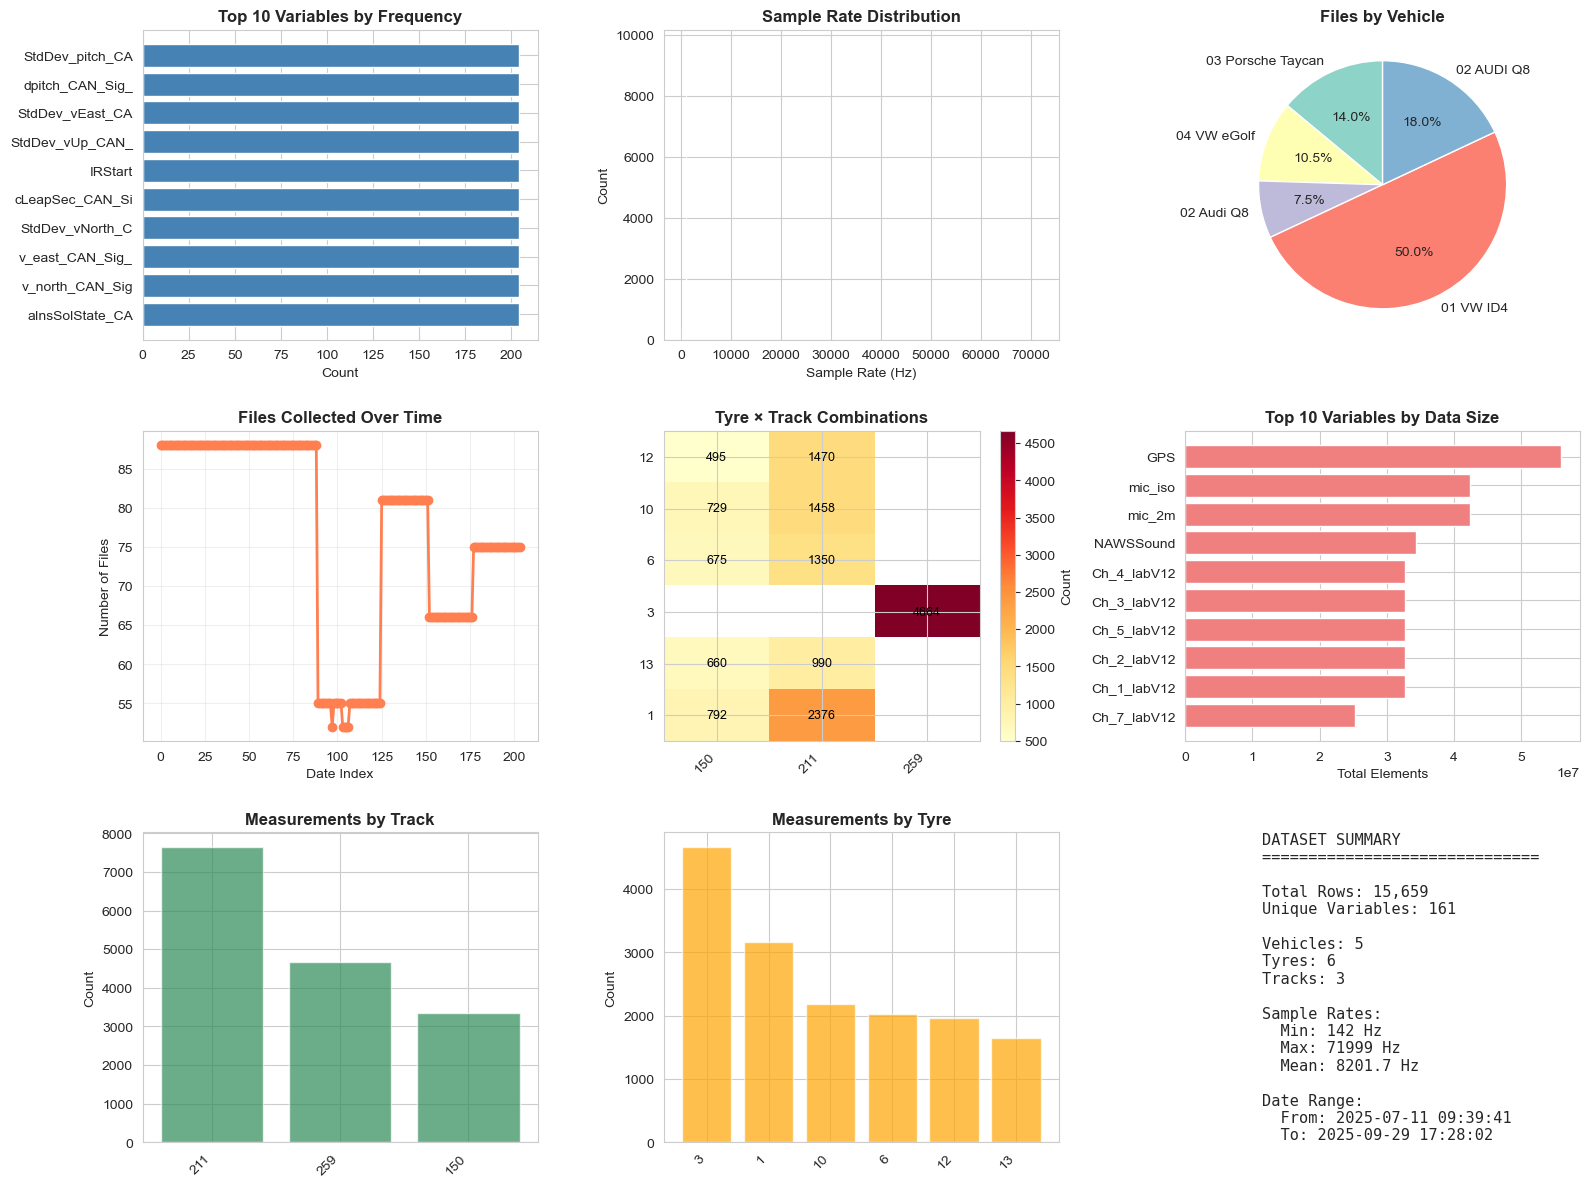

In [12]:
# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)


def plot_h5_analysis(df):
    """Generate comprehensive plots for H5 dataset analysis"""

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # ============ 1. Variable Distribution ============
    ax1 = plt.subplot(3, 3, 1)
    variable_dist = (
        df.group_by("variable_name")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(10)
    )
    ax1.barh(
        variable_dist["variable_name"].to_list(),
        variable_dist["count"].to_list(),
        color="steelblue",
    )
    ax1.set_xlabel("Count")
    ax1.set_title("Top 10 Variables by Frequency", fontweight="bold")
    ax1.invert_yaxis()

    # ============ 2. Sample Rate Distribution ============
    ax2 = plt.subplot(3, 3, 2)
    sample_rate_dist = (
        df.group_by("sample_rate")
        .agg(pl.len().alias("count"))
        .sort("sample_rate")
        .filter(pl.col("sample_rate").is_not_null())
    )
    ax2.bar(
        sample_rate_dist["sample_rate"].to_list(),
        sample_rate_dist["count"].to_list(),
        color="mediumpurple",
        alpha=0.7,
    )
    ax2.set_xlabel("Sample Rate (Hz)")
    ax2.set_ylabel("Count")
    ax2.set_title("Sample Rate Distribution", fontweight="bold")

    # ============ 3. Vehicle Breakdown (Pie Chart) ============
    ax3 = plt.subplot(3, 3, 3)
    vehicle_breakdown = df.group_by("vehicle").agg(pl.len().alias("count"))
    colors = plt.cm.Set3(range(len(vehicle_breakdown)))  # type: ignore
    ax3.pie(
        vehicle_breakdown["count"].to_list(),
        labels=vehicle_breakdown["vehicle"].to_list(),
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
    )
    ax3.set_title("Files by Vehicle", fontweight="bold")

    # ============ 4. Files Over Time ============
    ax4 = plt.subplot(3, 3, 4)
    files_over_time = df.group_by("date").agg(pl.len().alias("count")).sort("date")
    ax4.plot(
        range(len(files_over_time)),
        files_over_time["count"].to_list(),
        marker="o",
        linewidth=2,
        markersize=6,
        color="coral",
    )
    ax4.set_xlabel("Date Index")
    ax4.set_ylabel("Number of Files")
    ax4.set_title("Files Collected Over Time", fontweight="bold")
    ax4.grid(True, alpha=0.3)

    # ============ 5. Tyre × Track Heatmap ============
    ax5 = plt.subplot(3, 3, 5)
    tyre_track = df.group_by(["tyre_ID", "track_ID"]).agg(pl.len().alias("count"))
    # Pivot for heatmap
    pivot_data = tyre_track.pivot(values="count", index="tyre_ID", on="track_ID")
    pivot_array = pivot_data.drop("tyre_ID").to_numpy()

    im = ax5.imshow(pivot_array, cmap="YlOrRd", aspect="auto")
    ax5.set_xticks(range(len(pivot_data.columns[1:])))
    ax5.set_yticks(range(len(pivot_data)))
    ax5.set_xticklabels(pivot_data.columns[1:], rotation=45, ha="right")
    ax5.set_yticklabels(pivot_data["tyre_ID"].to_list())
    ax5.set_title("Tyre × Track Combinations", fontweight="bold")
    plt.colorbar(im, ax=ax5, label="Count")

    # Add text annotations
    for i in range(len(pivot_data)):
        for j in range(len(pivot_data.columns[1:])):
            if not np.isnan(pivot_array[i, j]):
                ax5.text(
                    j,
                    i,
                    int(pivot_array[i, j]),  # type: ignore
                    ha="center",
                    va="center",
                    color="black",
                    fontsize=9,
                )

    # ============ 6. Data Size by Variable ============
    ax6 = plt.subplot(3, 3, 6)
    variable_sizes = (
        df.with_columns(
            pl.col("variable_shape")
            .list.eval(pl.element().product())
            .list.first()
            .alias("total_elements")
        )
        .group_by("variable_name")
        .agg(pl.col("total_elements").sum().alias("total_size"))
        .sort("total_size", descending=True)
        .head(10)
    )
    ax6.barh(
        variable_sizes["variable_name"].to_list(),
        variable_sizes["total_size"].to_list(),
        color="lightcoral",
    )
    ax6.set_xlabel("Total Elements")
    ax6.set_title("Top 10 Variables by Data Size", fontweight="bold")
    ax6.invert_yaxis()
    ax6.ticklabel_format(style="scientific", axis="x", scilimits=(0, 0))

    # ============ 7. Track Distribution ============
    ax7 = plt.subplot(3, 3, 7)
    track_dist = df.group_by("track_ID").agg(pl.len().alias("count")).sort("count", descending=True)
    ax7.bar(range(len(track_dist)), track_dist["count"].to_list(), color="seagreen", alpha=0.7)
    ax7.set_xticks(range(len(track_dist)))
    ax7.set_xticklabels(track_dist["track_ID"].to_list(), rotation=45, ha="right")
    ax7.set_ylabel("Count")
    ax7.set_title("Measurements by Track", fontweight="bold")

    # ============ 8. Tyre Distribution ============
    ax8 = plt.subplot(3, 3, 8)
    tyre_dist = df.group_by("tyre_ID").agg(pl.len().alias("count")).sort("count", descending=True)
    ax8.bar(range(len(tyre_dist)), tyre_dist["count"].to_list(), color="orange", alpha=0.7)
    ax8.set_xticks(range(len(tyre_dist)))
    ax8.set_xticklabels(tyre_dist["tyre_ID"].to_list(), rotation=45, ha="right")
    ax8.set_ylabel("Count")
    ax8.set_title("Measurements by Tyre", fontweight="bold")

    # ============ 9. Summary Statistics Box ============
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis("off")

    stats_text = f"""
    DATASET SUMMARY
    {"=" * 30}
    
    Total Rows: {len(df):,}
    Unique Variables: {df["variable_name"].n_unique()}
    
    Vehicles: {df["vehicle"].n_unique()}
    Tyres: {df["tyre_ID"].n_unique()}
    Tracks: {df["track_ID"].n_unique()}
    
    Sample Rates:
      Min: {df["sample_rate"].min()} Hz
      Max: {df["sample_rate"].max()} Hz
      Mean: {df["sample_rate"].mean():.1f} Hz
    
    Date Range:
      From: {df["date"].min()}
      To: {df["date"].max()}
    """

    ax9.text(0.1, 0.5, stats_text, fontsize=11, family="monospace", verticalalignment="center")

    plt.tight_layout()
    return fig


# Usage:
# fig = plot_h5_analysis(expanded_df)
# plt.show()
# plt.savefig('h5_analysis.png', dpi=300, bbox_inches='tight')


# ============ INDIVIDUAL DETAILED PLOTS ============


def plot_variable_shape_dimensions(df):
    """Plot distribution of variable dimensions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Number of dimensions per variable
    dim_counts = (
        df.with_columns(pl.col("variable_shape").list.len().alias("n_dims"))
        .group_by("n_dims")
        .agg(pl.len().alias("count"))
        .sort("n_dims")
    )

    ax1.bar(dim_counts["n_dims"].to_list(), dim_counts["count"].to_list(), color="teal", alpha=0.7)
    ax1.set_xlabel("Number of Dimensions")
    ax1.set_ylabel("Count")
    ax1.set_title("Distribution of Variable Dimensions", fontweight="bold")

    # Shape size distribution (log scale)
    sizes = df.with_columns(
        pl.col("variable_shape").list.eval(pl.element().product()).list.first().alias("size")
    ).filter(pl.col("size").is_not_null())

    ax2.hist(
        np.log10(sizes["size"].to_list()), bins=30, color="indianred", alpha=0.7, edgecolor="black"
    )
    ax2.set_xlabel("log10(Total Elements)")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Distribution of Variable Sizes (log scale)", fontweight="bold")

    plt.tight_layout()
    return fig


def plot_sample_rate_by_variable(df):
    """Plot sample rates for different variables"""
    fig, ax = plt.subplots(figsize=(12, 6))

    var_sample = (
        df.group_by(["variable_name", "sample_rate"])
        .agg(pl.len().alias("count"))
        .filter(pl.col("sample_rate").is_not_null())
        .sort(["variable_name", "sample_rate"])
    )

    # Get unique variables and sample rates
    variables = var_sample["variable_name"].unique().to_list()  # [:15]  # Top 15
    var_filtered = var_sample.filter(pl.col("variable_name").is_in(variables))

    # Create scatter plot
    for var in variables:
        var_data = var_filtered.filter(pl.col("variable_name") == var)
        ax.scatter(
            var_data["sample_rate"].to_list(),
            [var] * len(var_data),
            s=var_data["count"].to_list(),
            alpha=0.6,
        )

    ax.set_xlabel("Sample Rate (Hz)")
    ax.set_ylabel("Variable Name")
    ax.set_title("Sample Rates by Variable (bubble size = count)", fontweight="bold")
    ax.grid(True, alpha=0.3, axis="x")

    plt.tight_layout()
    return fig


fig = plot_h5_analysis(files_df_expanded)

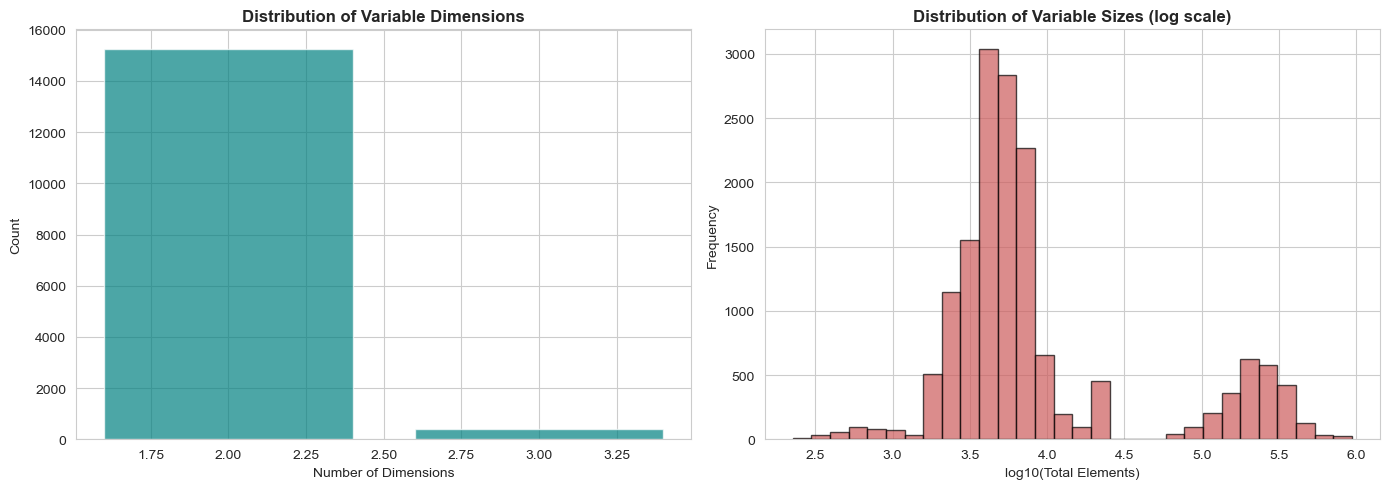

In [13]:
fig2 = plot_variable_shape_dimensions(files_df_expanded)

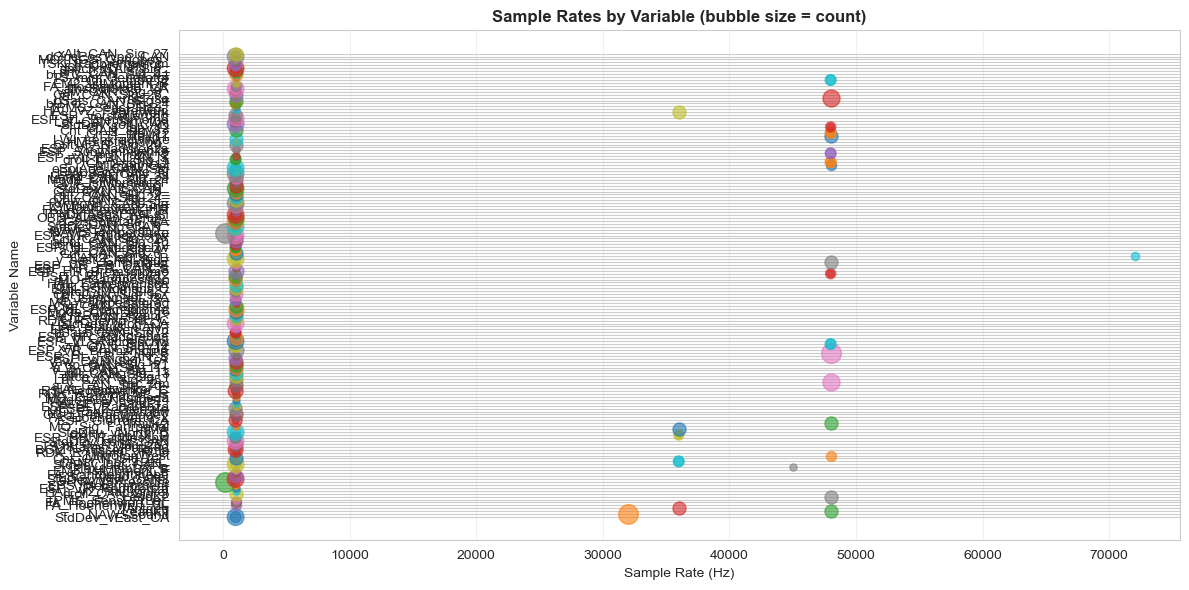

In [14]:
fig3 = plot_sample_rate_by_variable(files_df_expanded)

In [ ]:
files_df

In [16]:
file2 = files_df.filter(pl.col("vehicle") == "03 Porsche Taycan")["file_path"][0]

In [17]:
def extract_h5_variables2(filename):
    """Extract variable information from an HDF5 file."""
    variables = []

    with h5py.File(filename, "r") as f:

        def collect_datasets(name, obj):
            if isinstance(obj, h5py.Dataset):
                # Get sample_rate from attributes if it exists
                sample_rate = obj.attrs.get("sample_rate", None)
                if isinstance(sample_rate, np.ndarray):
                    sample_rate = sample_rate.astype(np.int32).item()
                else:
                    sample_rate = None

                variables.append(
                    {
                        "variable_name": name,
                        "variable_shape": list(obj.shape),
                        "sample_rate": sample_rate,
                        "unit": obj.attrs.get("unit", None),
                    }
                )

        f.visititems(collect_datasets)

    return variables


extract_h5_variables2(file2)

[{'variable_name': 'CAN1_labCTRLI_',
  'variable_shape': [1, 174600],
  'sample_rate': 36000,
  'unit': Empty(dtype=dtype('O'))},
 {'variable_name': 'CAN1_labDX_B',
  'variable_shape': [1, 174600],
  'sample_rate': 36000,
  'unit': Empty(dtype=dtype('O'))},
 {'variable_name': 'Ch_1_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_2_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_3_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_4_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_5_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'V'},
 {'variable_name': 'Ch_7_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': '%'},
 {'variable_name': 'Ch_8_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'un